In [1]:
# setup
# import latex_plots
import matplotlib.pyplot as plt, numpy as np
from IPython.core.display import display, HTML
from matplotlib.ticker import MultipleLocator
from pylab import rcParams
from numpy.fft import fftshift as shift
from astropy import units as u, constants as c
from matplotlib.ticker import MultipleLocator

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Functions
def iter_loadtxt(filename, delimiter=',', skiprows=0, dtype=float):
    def iter_func():
        with open(filename, 'r') as infile:
            for _ in range(skiprows):
                next(infile)
            for line in infile:
                line = line.rstrip().split(delimiter)
                for item in line:
                    yield dtype(item)
        iter_loadtxt.rowlength = len(line)

    data = np.fromiter(iter_func(), dtype=dtype)
    
    return data

def scale(data, volt_range):
    volt_dict = {'50mV':0.05, '100mV':0.1, '200mV':0.2, '500mV':0.5, '1V':1., '2V':2., '5V':5., '10V':10., '20V':20.} 
    return data * volt_dict[volt_range] / np.iinfo(np.int16).max 

def reshape_complex(data, nblocks, nsamples = 16000):
    split_data = np.array(np.split(data, nblocks * 2))
    imag_index = np.array((np.arange(0, 2 * nblocks) >= nblocks), dtype = bool)
    real_index = np.invert(imag_index)
    return split_data[real_index] + 1j*split_data[imag_index]

def power(data):
    return np.abs(np.fft.fft(data))**2

def freq_array(divisor, nsamples = 16000):
    sample_rate = (62.5*u.MHz / float(divisor)).to(u.Hz)
    dt = (1/sample_rate).to(u.s)
    return np.fft.fftfreq(nsamples, dt).to(u.MHz)

def time_array(divisor, units = 'us', nsamples = 16000):
    
    """Comput time array. X-axis for plotting time-series.
    
    Args:
        divisor         (int)   :   Indirect sample_rate control
        units           (str)   :   Time units for output array.
                                    --default = 'us' (microseconds)
        nsamples        (int)   :   Number of elements in Y-axis array
                                    --default = 16000

    Returns:
                    (ndarray)   :   1D array of Time in desired units
    """
    
    # Sample rate, in Hz
    sample_rate = (62.5*u.MHz / float(divisor)).to(u.Hz)

    # Time between samples, in seconds
    dt = (1/sample_rate).to(u.s)
    
    if units == 'us':
        return np.arange(0,nsamples) * dt.to(u.us)
    elif units == 'None' or units == None:
        return np.arange(0,nsamples) * dt

In [3]:
# global variables
nblocks = 50
divisor = 10
volt_range = '200mV'
nsamples = 16000
towers = 1


In [4]:
towers_1230 = np.zeros((towers, nblocks * 2 * nsamples))
for i in range(towers):
    filename = '1230MHz/tower_' + str(i) + '.txt'
    towers_1230[i, :] = iter_loadtxt(filename)
    print(towers - i)

1


In [5]:
towers_1230_s = scale(towers_1230, volt_range)[0]

In [6]:
towers_1230_s_s = towers_1230_s*1e3

In [7]:
towers_1230_s_s.shape

(1600000,)

In [8]:

# Define Gaussian distribution (Normalized when A = 1)
def gaussian(x, mu, sigma,A):
    return A*np.exp(-((x-mu)**2/(2*sigma**2)))

In [9]:
hist, bins = np.histogram(towers_1230_s_s, bins = 25)
hist = hist*1e-3
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
from scipy.optimize import curve_fit
popt, pcov = curve_fit(gaussian,
                           center,
                           hist)

array([-190.50581378, -174.63032929, -158.75484481, -142.87936033,
       -127.00387585, -111.12839137,  -95.25290689,  -79.37742241,
        -63.50193793,  -47.62645344,  -31.75096896,  -15.87548448,
          0.        ,   15.87548448,   31.75096896,   47.62645344,
         63.50193793,   79.37742241,   95.25290689,  111.12839137,
        127.00387585,  142.87936033,  158.75484481,  174.63032929,
        190.50581378])

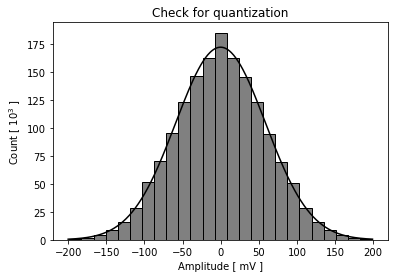

In [10]:
fig, ax = plt.subplots()
hist, bins = np.histogram(towers_1230_s_s, bins = 25)
hist = hist*1e-3
ax.set_xlabel('Amplitude [ mV ]')
ax.set_ylabel(r'Count [ $10^3$ ]')
ax.set_title('Check for quantization')
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax.bar(center, hist, align='center', width=width, color = 'gray', edgecolor='black', linewidth = 1)
ax.plot(np.arange(-200,200,1), gaussian(np.arange(-200,200,1),*popt), color = 'black')
plt.show()

array([-190.50581378, -174.63032929, -158.75484481, -142.87936033,
       -127.00387585, -111.12839137,  -95.25290689,  -79.37742241,
        -63.50193793,  -47.62645344,  -31.75096896,  -15.87548448,
          0.        ,   15.87548448,   31.75096896,   47.62645344,
         63.50193793,   79.37742241,   95.25290689,  111.12839137,
        127.00387585,  142.87936033,  158.75484481,  174.63032929,
        190.50581378])

In [86]:
from  matplotlib import rcParams

In [ ]:
# mean_ = np.mean(data)
# std_ = np.std(data)

# gauss_x = np.linspace(-6*std_,6*std_)
# gauss = gaussian(gauss_x, mean_, std_,1)

# ax.plot(gauss_x,
#         gauss,
#         color = 'black',
#         linewidth = 5)

# # Define Gaussian distribution (Normalized when A = 1)
# def gaussian(x, mu, sigma,A):
#     return A*((2*np.pi*sigma**2)**(-1/2))*np.exp(-((x-mu)**2/(2*sigma**2)))



In [11]:
popt

array([  -0.17740195,   58.89862272,  172.21913588])